In [ ]:
#TODO: move from jupyter to .py

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline

import numpy as np
from numpy.linalg import norm
import pandas as pd 

import seaborn as sns
import missingno

from sklearn import metrics
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold, RepeatedKFold, GroupKFold, GridSearchCV

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor, CatBoostClassifier

In [3]:
df = pd.read_csv ('.\online_jewellery_shop_train.csv')

print(df.keys())

Index(['ID', 'Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')


In [4]:
#df = df.values
# ['ID', 'Administrative', 'Administrative_Duration', 'Informational',
    #    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
    #    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
    #    'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
    #    'Weekend', 'Revenue']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Month'] = le.fit_transform(df['Month'])
df['VisitorType'] = le.fit_transform(df['VisitorType'])
# for i in range(df.shape[1]):
#     df[:,i] = le.fit_transform(df[:,i])

In [31]:
#feature engineering
df['avg_adm_dur'] = df['Administrative_Duration']/df['Administrative']
df['avg_inf_dur'] = df['Informational_Duration']/df['Informational']
df['avg_prod_dur'] = df['ProductRelated_Duration']/df['ProductRelated']


In [38]:
# #Normalize
# df['Administrative_Duration'] = (df['Administrative_Duration'] - df['Administrative_Duration'].mean())/df['Administrative_Duration'].std()
# df['Informational']	= (df['Informational'] - df['Informational'].mean())/df['Informational'].std()
# df['Informational_Duration'] = (df['Informational_Duration'] - df['Informational_Duration'].mean())/df['Informational_Duration'].std()
# df['ProductRelated'] = (df['ProductRelated'] - df['ProductRelated'].mean())/df['ProductRelated'].std()
# df['ProductRelated_Duration'] = (df['ProductRelated_Duration'] - df['ProductRelated_Duration'].mean())/df['ProductRelated_Duration'].std()
# df['BounceRates'] = (df['BounceRates'] - df['BounceRates'].mean())/df['BounceRates'].std()
# df['ExitRates'] = (df['ExitRates'] - df['ExitRates'].mean())/df['ExitRates'].std()
# df['PageValues'] = (df['PageValues'] - df['PageValues'].mean())/df['PageValues'].std()
# df['SpecialDay'] = (df['SpecialDay'] - df['SpecialDay'].mean())/df['SpecialDay'].std()
# df['avg_adm_dur'] = (df['avg_adm_dur'] - df['avg_adm_dur'].mean())/df['avg_adm_dur'].std()
# df['avg_inf_dur'] = (df['avg_inf_dur'] - df['avg_inf_dur'].mean())/df['avg_inf_dur'].std()
# df['avg_prod_dur'] =(df['avg_prod_dur'] - df['avg_prod_dur'].mean())/df['avg_prod_dur'].std()

In [5]:
df = df.fillna(0)
display(df)
df.info() #8 missing values

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,3935,1.0,50.333333,0.0,0.00,21.0,586.189286,0.000000,0.005556,0.0,0.6,6,1,1,1,2,2,0,0
1,7866,6.0,299.000000,1.0,41.00,36.0,696.402778,0.000000,0.002632,0.0,0.0,6,2,2,2,4,0,1,0
2,3727,0.0,0.000000,0.0,0.00,19.0,620.033333,0.000000,0.007895,0.0,0.0,2,1,1,4,2,2,0,0
3,4454,0.0,0.000000,0.0,0.00,4.0,46.250000,0.050000,0.066667,0.0,0.0,7,3,2,6,13,2,0,0
4,6186,0.0,0.000000,0.0,0.00,24.0,671.088653,0.026667,0.036566,0.0,0.0,7,1,1,3,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8625,5935,0.0,0.000000,0.0,0.00,29.0,873.750000,0.000000,0.031034,0.0,0.0,7,2,2,5,2,2,1,1
8626,7455,10.0,198.243056,3.0,276.25,151.0,4344.919986,0.002532,0.011966,0.0,0.0,1,4,2,4,2,2,0,0
8627,7853,0.0,0.000000,0.0,0.00,7.0,431.533333,0.000000,0.007143,0.0,0.0,8,2,2,1,2,2,0,0
8628,7355,2.0,16.000000,0.0,0.00,16.0,381.686508,0.011765,0.046569,0.0,0.6,2,2,4,2,1,2,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8630 entries, 0 to 8629
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8630 non-null   int64  
 1   Administrative           8630 non-null   float64
 2   Administrative_Duration  8630 non-null   float64
 3   Informational            8630 non-null   float64
 4   Informational_Duration   8630 non-null   float64
 5   ProductRelated           8630 non-null   float64
 6   ProductRelated_Duration  8630 non-null   float64
 7   BounceRates              8630 non-null   float64
 8   ExitRates                8630 non-null   float64
 9   PageValues               8630 non-null   float64
 10  SpecialDay               8630 non-null   float64
 11  Month                    8630 non-null   int32  
 12  OperatingSystems         8630 non-null   int64  
 13  Browser                  8630 non-null   int64  
 14  Region                  

In [6]:
#prelim data processing

#what about normalizing?



#change type
df['VisitorType'] = df['VisitorType'].astype('category')
df['Month'] = df['Month'].astype('category')

#is this necessary?
df['Revenue'] = df['Revenue'].astype('category')
df['Weekend'] = df['Weekend'].astype('category')
df['OperatingSystems'] = df['OperatingSystems'].astype('category')
df['Browser'] = df['Browser'].astype('category')
df['Region'] = df['Region'].astype('category')


In [ ]:
#hoe is the data distribution? do we need to normalize features?

#how to deal with 8 lines of missing value? i put it to 0 based on my intuition

In [8]:
# #over/undersampling

# from sklearn.utils import resample

# # # setting up testing and training sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# # # concatenate our training data back together
# # df = pd.concat([X_train, y_train], axis=1)

# # Separate majority and minority classes
# # Separate majority and minority classes
# df_majority = df[df.Revenue==0]
# df_minority = df[df.Revenue==1]

# # Upsample minority class
# df_majority_upsampled = resample(df_majority, 
#                                  replace=False,     # sample with replacement
#                                  n_samples=len(df_minority),    # to match majority class
#                                  random_state=1234) # reproducible results
 
# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_minority, df_majority_upsampled])
 
# # Display new class counts
# df_upsampled.Revenue.value_counts()


# #####################TO BE CHANGED
# df = df_upsampled

# from sklearn.utils import shuffle
# df = shuffle(df)

In [7]:
# #over/undersampling

# from sklearn.utils import resample

# # # setting up testing and training sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# # # concatenate our training data back together
# # df = pd.concat([X_train, y_train], axis=1)

# # Separate majority and minority classes
# # Separate majority and minority classes
# df_minority = df[df.Revenue==0]
# df_majority = df[df.Revenue==1]

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=False,     # sample with replacement
#                                  n_samples=len(df_majority),    # to match majority class
#                                  random_state=1234) # reproducible results
 
# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# # Display new class counts
# df_upsampled.Revenue.value_counts()


# #####################TO BE CHANGED
# df = df_upsampled

# from sklearn.utils import shuffle
# df = shuffle(df)

In [7]:
y = df['Revenue']
X = df.drop(['Revenue','ID'], axis=1) #, 'ID','BounceRates' 
#,'Administrative_Duration','Administrative','Informational_Duration','Informational','ProductRelated_Duration','ProductRelated'

##
# setting up testing and training sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=27)

In [8]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict



def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True

def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

In [ ]:
# lg = lgb.LGBMClassifier(silent=False)
# param_dist = {"max_depth": [10,13,16,19,22,25],
#               "learning_rate" : [0.03,0.05,0.07],
#               "num_leaves": [10,13,16,19,22,25],
#               "n_estimators": [200,400,600,800,1000]
#              }
# grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=-1)
# grid_search.fit(X,y)
# grid_search.best_estimator_

# # d_train = lgb.Dataset(train, label=y_train)
# # params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}


# # #With Catgeorical Features
# # cate_features_name = ['PageValues', 'Month',
# #        'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend']
# # model2 = lgb.train(params, d_train, categorical_feature = cate_features_name)
# # auc2(model2, train, test)


In [91]:
# from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.model_selection import train_test_split
# import neptunecontrib.monitoring.skopt as sk_utils
# import lightgbm as lgb
# import pandas as pd
# import neptune
# import skopt
# import sys
# import os
# SEARCH_PARAMS = {'learning_rate': 0.4,
#                  'max_depth': 15,
#                  'num_leaves': 20,
#                  'feature_fraction': 0.8,
#                  'subsample': 0.2,
#                  'reg_lambda':0.3}

# FIXED_PARAMS={'objective': 'binary',
#               'metric': 'auc',
#               'is_unbalance':True,
#               'boosting':'gbdt',
#               'num_boost_round':300,
#               'early_stopping_rounds':200,
#               'min_child_samples': 79,
#                 "subsample_freq": 3,
#                 "bagging_seed": 11,
#                 "verbosity": -1,
#                 'reg_alpha': 0.3,
#                 'colsample_bytree': 0.9}

# def train_evaluate(search_params):
#    # you can download the dataset from this link(https://www.kaggle.com/c/santander-customer-transaction-prediction/data)
#    # import Dataset to play with it
#     df = pd.read_csv ('.\online_jewellery_shop_train.csv')
#     from sklearn import preprocessing
#     le = preprocessing.LabelEncoder()
#     df['Month'] = le.fit_transform(df['Month'])
#     df['VisitorType'] = le.fit_transform(df['VisitorType'])
#     df['avg_adm_dur'] = df['Administrative_Duration']/df['Administrative']
#     df['avg_inf_dur'] = df['Informational_Duration']/df['Informational']
#     df['avg_prod_dur'] = df['ProductRelated_Duration']/df['ProductRelated']
#     df = df.fillna(0)
#     y = df['Revenue']
#     X = df.drop(['Revenue','ID'], axis=1)
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1234)
#     train_data = lgb.Dataset(X_train, label=y_train)
#     valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

#     params = {'metric':FIXED_PARAMS['metric'],
#                 'objective':FIXED_PARAMS['objective'],
#                 **search_params}

#     model = lgb.train(params, train_data,                     
#                         valid_sets=[valid_data],
#                         num_boost_round=FIXED_PARAMS['num_boost_round'],
#                         early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
#                         valid_names=['valid'])
#     score = model.best_score['valid']['auc']
#     return score

3
[257]	valid's auc: 0.906924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid's auc: 0.906874
[259]	valid's auc: 0.906827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid's auc: 0.906902
[261]	valid's auc: 0.906794
[262]	valid's auc: 0.906401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid's auc: 0.906258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid's auc: 0.906598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid's auc: 0.906595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid's auc: 0.906609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[267]	valid's auc: 0.906736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[268]	valid's auc: 0.90683
[LightGBM] [Warning] No further splits with positive gain, best

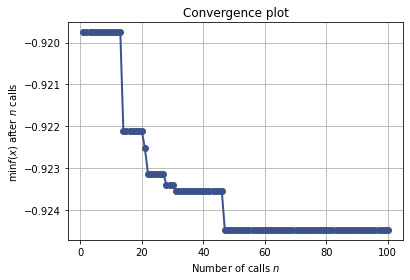

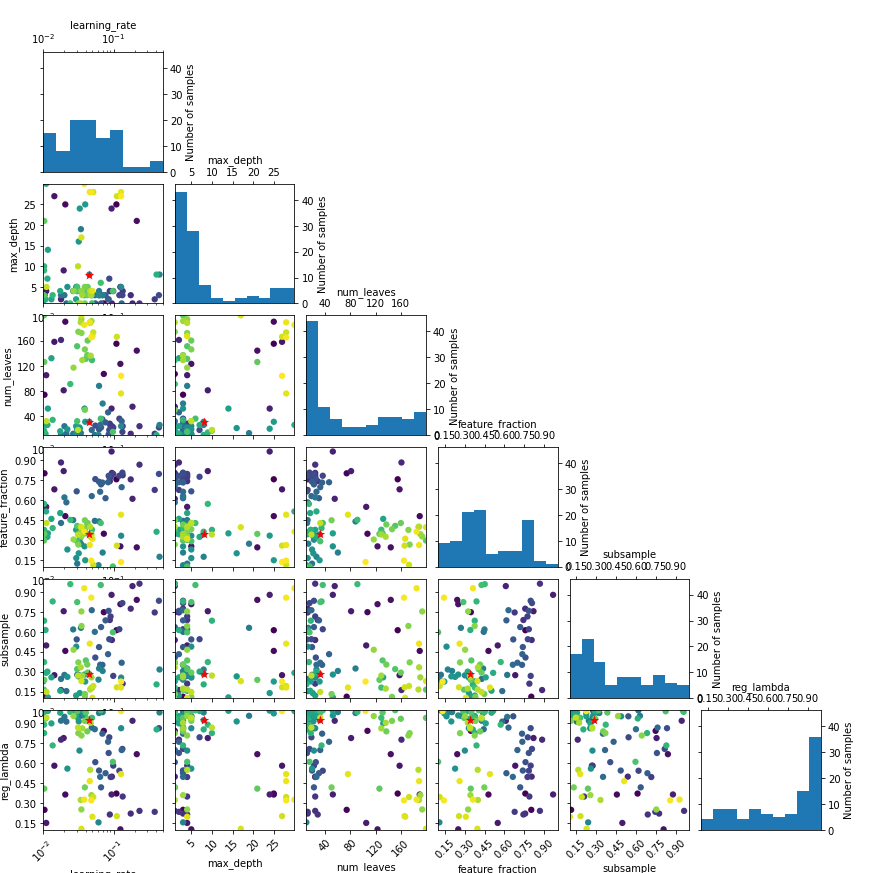

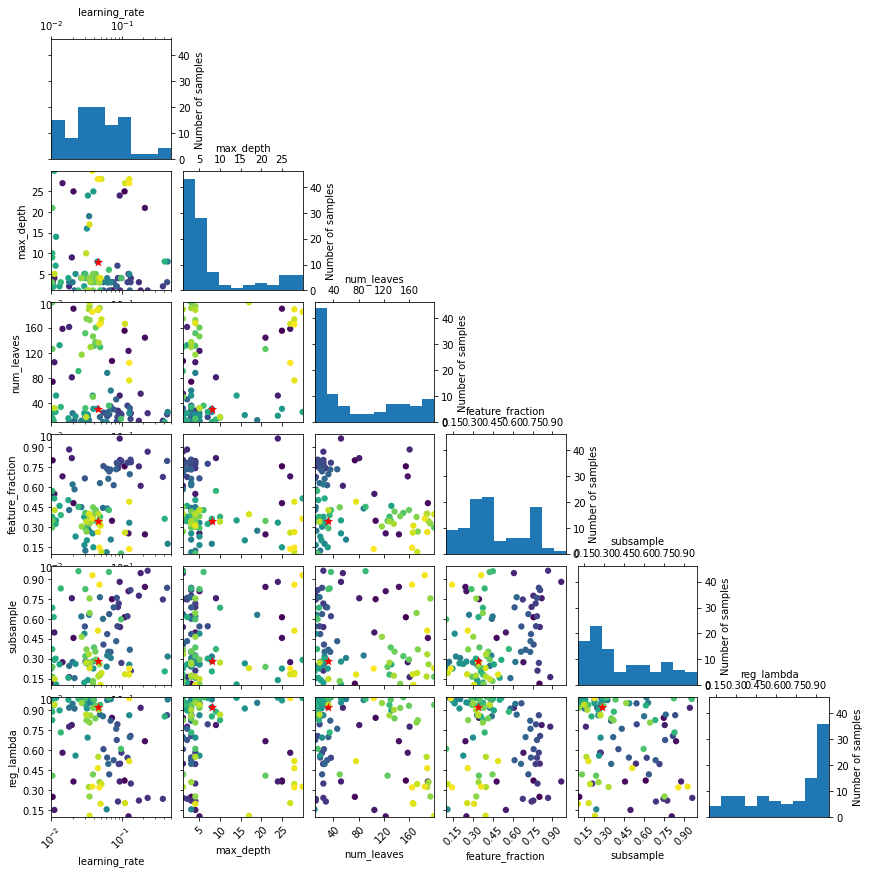

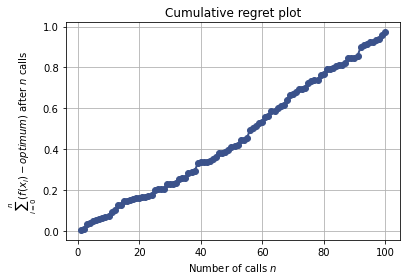

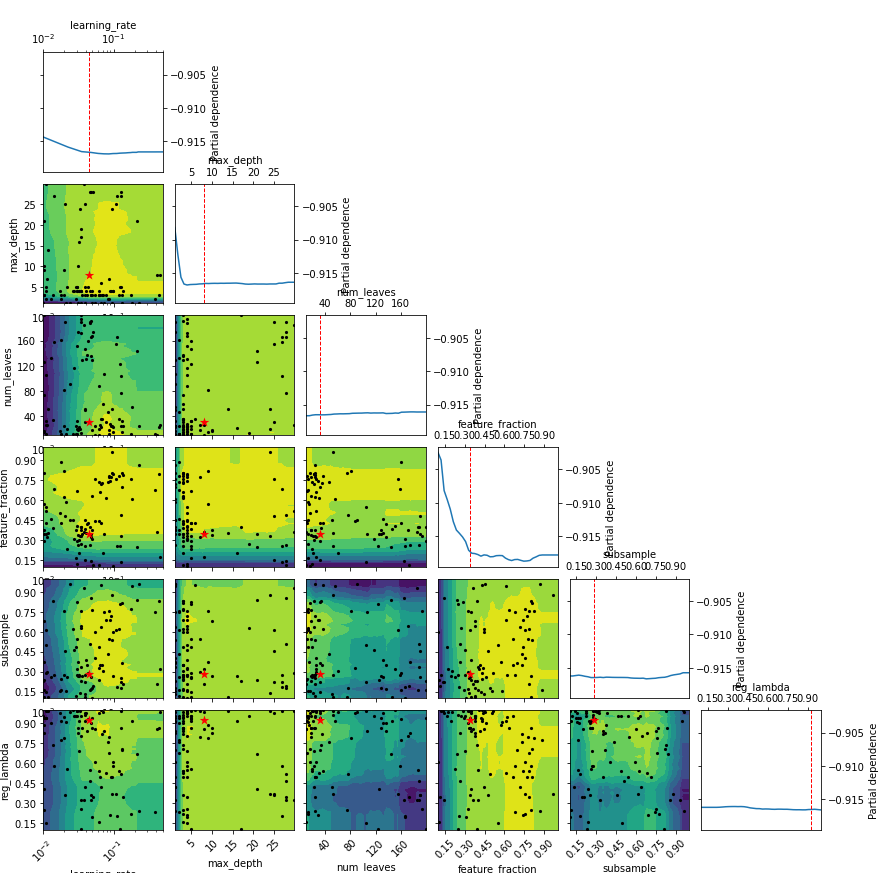

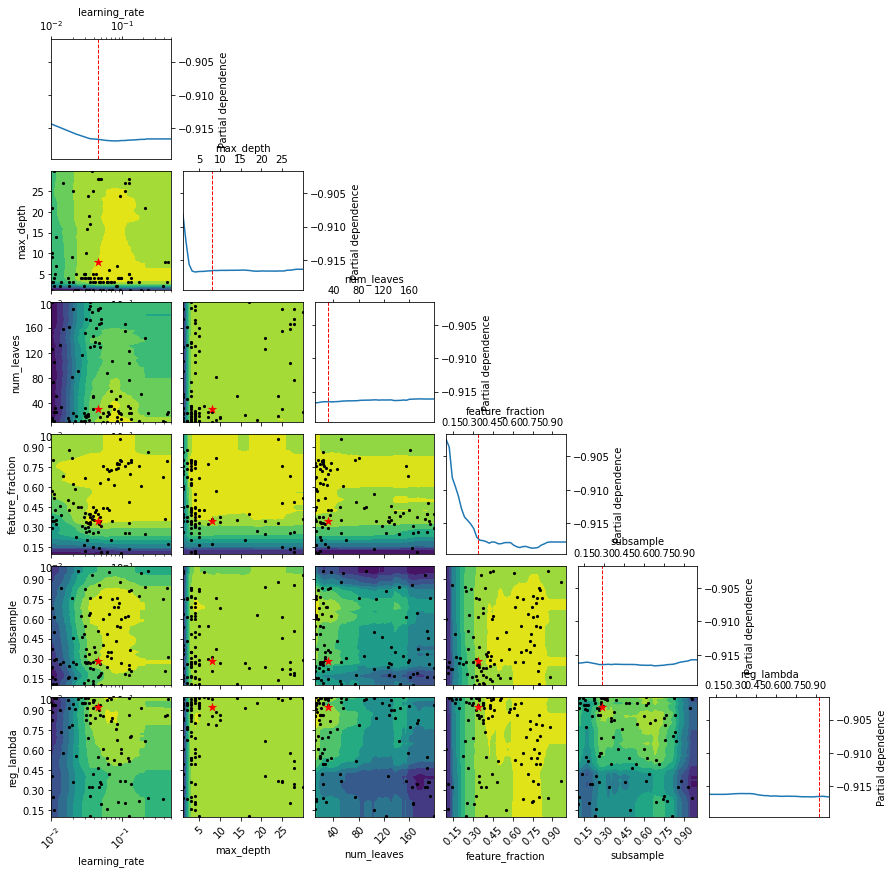

In [92]:
# neptune.init('phoebecmk/sandbox', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDA4MDE3YmUtMDBkZC00OTM1LWI0ZGQtMGRmNTEyNWY2MGRkIn0=')
# neptune.create_experiment('lgb-tuning_final', upload_source_files=['*.*'],
#                               tags=['lgb-tuning', 'dart'],params=SEARCH_PARAMS)

# SPACE = [
#    skopt.space.Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
#    skopt.space.Integer(1, 30, name='max_depth'),
#    skopt.space.Integer(10, 200, name='num_leaves'),
#    skopt.space.Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
#    skopt.space.Real(0.1, 1.0, name='subsample', prior='uniform'),
#    skopt.space.Real(0.1, 1.0, name='reg_lambda', prior='uniform')
# ]
# @skopt.utils.use_named_args(SPACE)
# def objective(**params):
#    return -1.0 * train_evaluate(params)

# monitor = sk_utils.NeptuneMonitor()
# results = skopt.forest_minimize(objective, SPACE, 
#                                 n_calls=100, n_random_starts=10, 
#                                 callback=[monitor])
# sk_utils.log_results(results)

# neptune.stop()

In [9]:
#report predicted values
test_X_final = pd.read_csv ('.\online_jewellery_shop_test_final.csv')
test_X_final['avg_adm_dur'] = test_X_final['Administrative_Duration']/test_X_final['Administrative']
test_X_final['avg_inf_dur'] = test_X_final['Informational_Duration']/test_X_final['Informational']
test_X_final['avg_prod_dur'] = test_X_final['ProductRelated_Duration']/test_X_final['ProductRelated']
 #'Administrative_Duration','Administrative','Informational_Duration','Informational','ProductRelated_Duration','ProductRelated'
test_X_final = test_X_final.fillna(0)
le = preprocessing.LabelEncoder()
test_X_final['Month'] = le.fit_transform(test_X_final['Month'])
test_X_final['VisitorType'] = le.fit_transform(test_X_final['VisitorType'])



In [10]:
#change type
test_X_final['VisitorType'] = test_X_final['VisitorType'].astype('category')
test_X_final['Month'] = test_X_final['Month'].astype('category')

#is this necessary?
test_X_final['Weekend'] = test_X_final['Weekend'].astype('category')
test_X_final['OperatingSystems'] = test_X_final['OperatingSystems'].astype('category')
test_X_final['Browser'] = test_X_final['Browser'].astype('category')
test_X_final['Region'] = test_X_final['Region'].astype('category')
test_X_final = test_X_final.drop(['ID'], axis=1)

Fold 1 started at Fri Oct 23 23:41:34 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[172]	training's auc: 0.975243	training's auc: 0.975243	valid_1's auc: 0.917721	valid_1's auc: 0.917721
Fold 2 started at Fri Oct 23 23:42:40 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	training's auc: 0.954411	training's auc: 0.954411	valid_1's auc: 0.945502	valid_1's auc: 0.945502
Fold 3 started at Fri Oct 23 23:43:29 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[295]	training's auc: 0.98868	training's auc: 0.98868	valid_1's auc: 0.926944	valid_1's auc: 0.926944
Fold 4 started at Fri Oct 23 23:45:37 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	training's auc: 0.967234	training's auc: 0.967234	valid_1's auc: 0.946786	valid_1's auc: 0.946786
Fold 5 started at Fri Oct 2

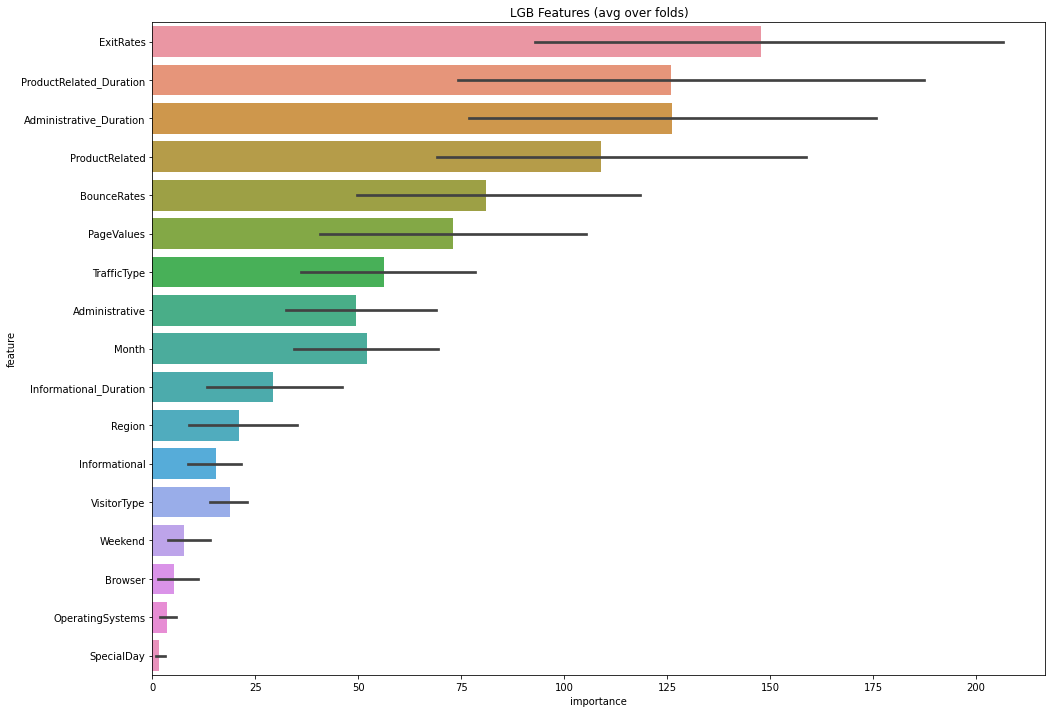

In [12]:
#try LGBM

n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

# params = {'learning_rate': 0.04526602795873251,
#                  'max_depth': 8,
#                  'num_leaves': 31,
#                  'feature_fraction': 0.3421269241936452,
#                  'subsample': 0.281411130711204,
#                  'reg_lambda':0.9246006345314853,
                 
#                  'objective': 'binary',
#               'metric': 'auc',
#               #'is_unbalance':True,
#               'boosting':'gbdt',
#               'num_boost_round':300,
#               'early_stopping_rounds':200,
#               'min_child_samples': 79,
#                 "subsample_freq": 3,
#                 "bagging_seed": 11,
#                 "verbosity": -1,
#                 'reg_alpha': 0.3,
#                 'colsample_bytree': 0.9}



#i dont remember the params i tuned it with.... but it's similar to the ones here
params = {'num_leaves': 18,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols'
         }
result_dict_lgb = train_model_classification(X=X, X_test=test_X_final, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True, verbose=500, early_stopping_rounds=200, n_estimators=4000, averaging='usual', n_jobs=-1)


In [13]:
test_X_final = pd.read_csv ('.\online_jewellery_shop_test_final.csv')
results = pd.DataFrame([])
results['ID'] = test_X_final['ID']
results['Revenue'] =result_dict_lgb['prediction']
results.to_csv('.\submission.csv', index = False)

In [47]:
# #try decision tree
# from sklearn.ensemble import RandomForestClassifier

# # train model
# rfc = RandomForestClassifier(n_estimators=30).fit(train_x, train_y)

# # predict on test set
# rfc_pred = rfc.predict(test_x)

# #evaluation criteria
# print(roc_auc_score(test_y, rfc_pred))

# #training
# rfc_pred = rfc.predict(train_x)
# print(roc_auc_score(train_y, rfc_pred))


0.7641977282329776
0.9939879759519038


In [10]:
# from sklearn.svm import SVC
# svclassifier = SVC(kernel='linear')
# rfc = svclassifier.fit(train_x, train_y)
# # predict on test set
# rfc_pred = rfc.predict(test_x)

# #evaluation criteria
# print(roc_auc_score(test_y, rfc_pred))

# #training
# rfc_pred = rfc.predict(train_x)
# print(roc_auc_score(train_y, rfc_pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [34]:
# #Normalize
# test_X_final['Administrative_Duration'] = (test_X_final['Administrative_Duration'] - test_X_final['Administrative_Duration'].mean())/test_X_final['Administrative_Duration'].std()
# test_X_final['Informational']	= (test_X_final['Informational'] - test_X_final['Informational'].mean())/test_X_final['Informational'].std()
# test_X_final['Informational_Duration'] = (test_X_final['Informational_Duration'] - test_X_final['Informational_Duration'].mean())/test_X_final['Informational_Duration'].std()
# test_X_final['ProductRelated'] = (test_X_final['ProductRelated'] - test_X_final['ProductRelated'].mean())/test_X_final['ProductRelated'].std()
# test_X_final['ProductRelated_Duration'] = (test_X_final['ProductRelated_Duration'] - test_X_final['ProductRelated_Duration'].mean())/test_X_final['ProductRelated_Duration'].std()
# test_X_final['BounceRates'] = (test_X_final['BounceRates'] - test_X_final['BounceRates'].mean())/test_X_final['BounceRates'].std()
# test_X_final['ExitRates'] = (test_X_final['ExitRates'] - test_X_final['ExitRates'].mean())/test_X_final['ExitRates'].std()
# test_X_final['PageValues'] = (test_X_final['PageValues'] - test_X_final['PageValues'].mean())/test_X_final['PageValues'].std()
# test_X_final['SpecialDay'] = (test_X_final['SpecialDay'] - test_X_final['SpecialDay'].mean())/test_X_final['SpecialDay'].std()
# test_X_final['avg_adm_dur'] = (test_X_final['avg_adm_dur'] - test_X_final['avg_adm_dur'].mean())/test_X_final['avg_adm_dur'].std()
# test_X_final['avg_inf_dur'] = (test_X_final['avg_inf_dur'] - test_X_final['avg_inf_dur'].mean())/test_X_final['avg_inf_dur'].std()
# test_X_final['avg_prod_dur'] =(test_X_final['avg_prod_dur'] - test_X_final['avg_prod_dur'].mean())/test_X_final['avg_prod_dur'].std()

In [ ]:
# pred_p = rfc.predict_proba(test_X_final)
# results = pd.DataFrame([])
# results['ID'] = test_X_final['ID']
# results['Revenue'] =pred_p.T[1]
# results.to_csv('.\submission.csv', index = False)